In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/B/practical-machine-learning-with-python/Ch09_Analyzing_Wine_Types_and_Quality'

/content/drive/MyDrive/B/practical-machine-learning-with-python/Ch09_Analyzing_Wine_Types_and_Quality


#Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score,classification_report
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

#Load datasets

In [ ]:
white_wine = pd.read_csv('winequality-white.csv', sep=';')
red_wine = pd.read_csv('winequality-red.csv', sep=';')

# store wine type as an attribute
red_wine['wine_type'] = 'red'   
white_wine['wine_type'] = 'white'
# bucket wine quality scores into qualitative quality labels
red_wine['quality_label'] = red_wine['quality'].apply(lambda value: 'low' 
                                                          if value <= 5 else 'medium' 
                                                              if value <= 6 else 'high')
red_wine['quality_label'] = pd.Categorical(red_wine['quality_label'], 
                                           categories=['low', 'medium', 'high'])
white_wine['quality_label'] = white_wine['quality'].apply(lambda value: 'low' 
                                                              if value <= 5 else 'medium' 
                                                                  if value <= 6 else 'high')
white_wine['quality_label'] = pd.Categorical(white_wine['quality_label'], 
                                             categories=['low', 'medium', 'high'])

# merge red and white wine datasets
wines = pd.concat([red_wine, white_wine])
# re-shuffle records just to randomize data points
wines = wines.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
print(white_wine.shape, red_wine.shape)

(4898, 14) (1599, 14)


In [ ]:
subset_attributes = ['residual sugar', 'total sulfur dioxide', 'sulphates', 'alcohol', 'volatile acidity', 'quality']
rs = round(red_wine[subset_attributes].describe(),2)
ws = round(white_wine[subset_attributes].describe(),2)
pd.concat([rs, ws], axis=1, keys=['Red Wine Statistics', 'White Wine Statistics'])

Red Wine Statistics                                          \
           residual sugar total sulfur dioxide sulphates  alcohol   
count             1599.00              1599.00   1599.00  1599.00   
mean                 2.54                46.47      0.66    10.42   
std                  1.41                32.90      0.17     1.07   
min                  0.90                 6.00      0.33     8.40   
25%                  1.90                22.00      0.55     9.50   
50%                  2.20                38.00      0.62    10.20   
75%                  2.60                62.00      0.73    11.10   
max                 15.50               289.00      2.00    14.90   

                                White Wine Statistics                       \
      volatile acidity  quality        residual sugar total sulfur dioxide   
count          1599.00  1599.00               4898.00              4898.00   
mean              0.53     5.64                  6.39               138.36   
std               0.18     0.81                  5.07                42.50   
min               0.12     3.00                  0.60                 9.00   
25%               0.39     5.00                  1.70               108.00   
50%               0.52     6.00                  5.20               134.00   
75%               0.64     6.00                  9.90               167.00   
max               1.58     8.00                 65.80               440.00   

                                                    
      sulphates  alcohol volatile acidity  quality  
count   4898.00  4898.00          4898.00  4898.00  
mean       0.49    10.51             0.28     5.88  
std        0.11     1.23             0.10     0.89  
min        0.22     8.00             0.08     3.00  
25%        0.41     9.50             0.21     5.00  
50%        0.47    10.40             0.26     6.00  
75%        0.55    11.40             0.32     6.00  
max        1.08    14.20             1.10     9.00

In [ ]:
subset_attributes = ['alcohol', 'volatile acidity', 'pH', 'quality']
ls = round(wines[wines['quality_label'] == 'low'][subset_attributes].describe(),2)
ms = round(wines[wines['quality_label'] == 'medium'][subset_attributes].describe(),2)
hs = round(wines[wines['quality_label'] == 'high'][subset_attributes].describe(),2)
pd.concat([ls, ms, hs], axis=1, keys=['Low Quality Wine', 'Medium Quality Wine', 'High Quality Wine'])

Low Quality Wine                                    Medium Quality Wine  \
               alcohol volatile acidity       pH  quality             alcohol   
count          2384.00          2384.00  2384.00  2384.00             2836.00   
mean              9.87             0.40     3.21     4.88               10.59   
std               0.84             0.19     0.16     0.36                1.13   
min               8.00             0.10     2.74     3.00                8.40   
25%               9.30             0.26     3.11     5.00                9.60   
50%               9.60             0.34     3.20     5.00               10.50   
75%              10.40             0.50     3.31     5.00               11.40   
max              14.90             1.58     3.90     5.00               14.00   

                                        High Quality Wine                   \
      volatile acidity       pH quality           alcohol volatile acidity   
count          2836.00  2836.00  2836.0           1277.00          1277.00   
mean              0.31     3.22     6.0             11.43             0.29   
std               0.15     0.16     0.0              1.22             0.12   
min               0.08     2.72     6.0              8.50             0.08   
25%               0.21     3.11     6.0             10.70             0.20   
50%               0.27     3.21     6.0             11.50             0.27   
75%               0.37     3.32     6.0             12.40             0.34   
max               1.04     4.01     6.0             14.20             0.92   

                         
            pH  quality  
count  1277.00  1277.00  
mean      3.23     7.16  
std       0.16     0.38  
min       2.84     7.00  
25%       3.12     7.00  
50%       3.22     7.00  
75%       3.34     7.00  
max       3.82     9.00

In [ ]:
from scipy import stats
 
F, p = stats.f_oneway(wines[wines['quality_label'] == 'low']['alcohol'], 
                      wines[wines['quality_label'] == 'medium']['alcohol'], 
                      wines[wines['quality_label'] == 'high']['alcohol'])
print('ANOVA test for mean alcohol levels across wine samples with different quality ratings')
print('F Statistic:', F, '\tp-value:', p)

F, p = stats.f_oneway(wines[wines['quality_label'] == 'low']['pH'], 
                      wines[wines['quality_label'] == 'medium']['pH'], 
                      wines[wines['quality_label'] == 'high']['pH'])
print('\nANOVA test for mean pH levels across wine samples with different quality ratings')
print('F Statistic:', F, '\tp-value:', p)

ANOVA test for mean alcohol levels across wine samples with different quality ratings
F Statistic: 936.9233871275493 	p-value: 0.0

ANOVA test for mean pH levels across wine samples with different quality ratings
F Statistic: 2.832279359487029 	p-value: 0.05895122846917114


Text(0, 0.5, 'Wine pH')

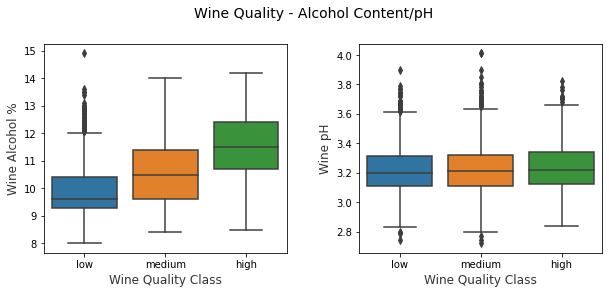

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
f.suptitle('Wine Quality - Alcohol Content/pH', fontsize=14)
f.subplots_adjust(top=0.85, wspace=0.3)

sns.boxplot(x="quality_label", y="alcohol",
            data=wines, ax=ax1)
ax1.set_xlabel("Wine Quality Class",size = 12,alpha=0.8)
ax1.set_ylabel("Wine Alcohol %",size = 12,alpha=0.8)

sns.boxplot(x="quality_label", y="pH", data=wines, ax=ax2)
ax2.set_xlabel("Wine Quality Class",size = 12,alpha=0.8)
ax2.set_ylabel("Wine pH",size = 12,alpha=0.8)

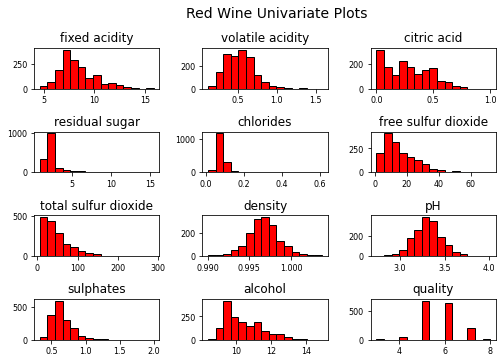

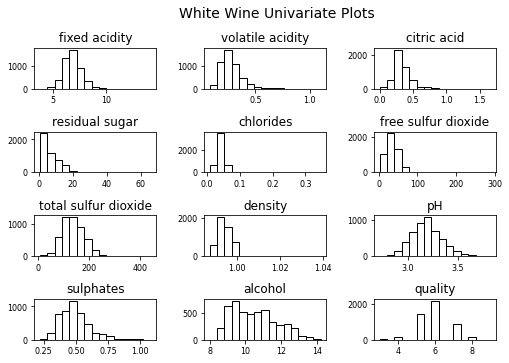

In [ ]:
red_wine.hist(bins=15, color='red', edgecolor='black', linewidth=1.0,
              xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   
rt = plt.suptitle('Red Wine Univariate Plots', x=0.65, y=1.25, fontsize=14)  

white_wine.hist(bins=15, color='white', edgecolor='black', linewidth=1.0,
              xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   
wt = plt.suptitle('White Wine Univariate Plots', x=0.65, y=1.25, fontsize=14)   

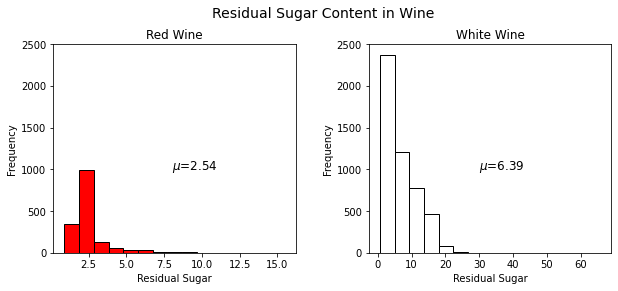

In [ ]:
fig = plt.figure(figsize = (10,4))
title = fig.suptitle("Residual Sugar Content in Wine", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("Red Wine")
ax1.set_xlabel("Residual Sugar")
ax1.set_ylabel("Frequency") 
ax1.set_ylim([0, 2500])
ax1.text(8, 1000, r'$\mu$='+str(round(red_wine['residual sugar'].mean(),2)), 
         fontsize=12)
r_freq, r_bins, r_patches = ax1.hist(red_wine['residual sugar'], color='red', bins=15,
                                    edgecolor='black', linewidth=1)

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("White Wine")
ax2.set_xlabel("Residual Sugar")
ax2.set_ylabel("Frequency")
ax2.set_ylim([0, 2500])
ax2.text(30, 1000, r'$\mu$='+str(round(white_wine['residual sugar'].mean(),2)), 
         fontsize=12)
w_freq, w_bins, w_patches = ax2.hist(white_wine['residual sugar'], color='white', bins=15,
                                    edgecolor='black', linewidth=1)

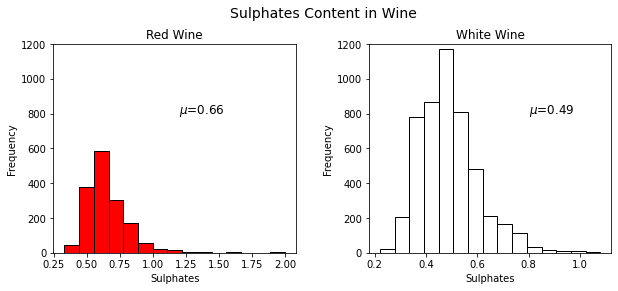

In [ ]:
fig = plt.figure(figsize = (10,4))
title = fig.suptitle("Sulphates Content in Wine", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("Red Wine")
ax1.set_xlabel("Sulphates")
ax1.set_ylabel("Frequency") 
ax1.set_ylim([0, 1200])
ax1.text(1.2, 800, r'$\mu$='+str(round(red_wine['sulphates'].mean(),2)), 
         fontsize=12)
r_freq, r_bins, r_patches = ax1.hist(red_wine['sulphates'], color='red', bins=15,
                                    edgecolor='black', linewidth=1)

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("White Wine")
ax2.set_xlabel("Sulphates")
ax2.set_ylabel("Frequency")
ax2.set_ylim([0, 1200])
ax2.text(0.8, 800, r'$\mu$='+str(round(white_wine['sulphates'].mean(),2)), 
         fontsize=12)
w_freq, w_bins, w_patches = ax2.hist(white_wine['sulphates'], color='white', bins=15,
                                    edgecolor='black', linewidth=1)

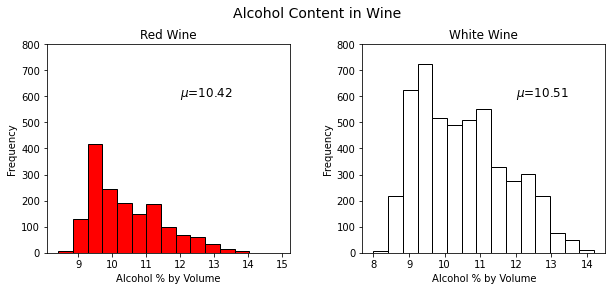

In [ ]:
fig = plt.figure(figsize = (10,4))
title = fig.suptitle("Alcohol Content in Wine", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("Red Wine")
ax1.set_xlabel("Alcohol % by Volume")
ax1.set_ylabel("Frequency") 
ax1.set_ylim([0, 800])
ax1.text(12, 600, r'$\mu$='+str(round(red_wine['alcohol'].mean(),2)), 
         fontsize=12)
r_freq, r_bins, r_patches = ax1.hist(red_wine['alcohol'], color='red', bins=15,
                                    edgecolor='black', linewidth=1)

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("White Wine")
ax2.set_xlabel("Alcohol % by Volume")
ax2.set_ylabel("Frequency")
ax2.set_ylim([0, 800])
ax2.text(12, 600, r'$\mu$='+str(round(white_wine['alcohol'].mean(),2)), 
         fontsize=12)
w_freq, w_bins, w_patches = ax2.hist(white_wine['alcohol'], color='white', bins=15,
                                    edgecolor='black', linewidth=1)

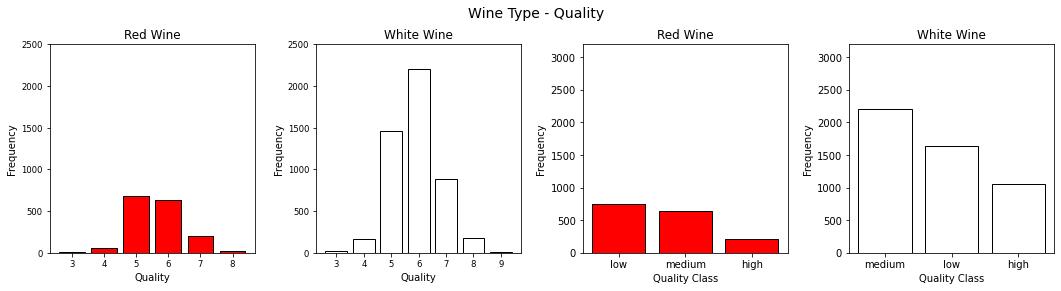

In [ ]:
fig = plt.figure(figsize = (18, 4))
title = fig.suptitle("Wine Type - Quality", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,4, 1)
ax1.set_title("Red Wine")
ax1.set_xlabel("Quality")
ax1.set_ylabel("Frequency") 
rw_q = red_wine['quality'].value_counts()
rw_q = (list(rw_q.index), list(rw_q.values))
ax1.set_ylim([0, 2500])
ax1.tick_params(axis='both', which='major', labelsize=8.5)
bar1 = ax1.bar(rw_q[0], rw_q[1], color='red', 
        edgecolor='black', linewidth=1)


ax2 = fig.add_subplot(1,4, 2)
ax2.set_title("White Wine")
ax2.set_xlabel("Quality")
ax2.set_ylabel("Frequency") 
ww_q = white_wine['quality'].value_counts()
ww_q = (list(ww_q.index), list(ww_q.values))
ax2.set_ylim([0, 2500])
ax2.tick_params(axis='both', which='major', labelsize=8.5)
bar2 = ax2.bar(ww_q[0], ww_q[1], color='white', 
        edgecolor='black', linewidth=1)

ax3 = fig.add_subplot(1,4, 3)
ax3.set_title("Red Wine")
ax3.set_xlabel("Quality Class")
ax3.set_ylabel("Frequency") 
rw_q = red_wine['quality_label'].value_counts()
rw_q = (list(rw_q.index), list(rw_q.values))
ax3.set_ylim([0, 3200])
bar3 = ax3.bar(list(range(len(rw_q[0]))), rw_q[1], color='red', 
        edgecolor='black', linewidth=1, tick_label =rw_q[0])

ax4 = fig.add_subplot(1,4, 4)
ax4.set_title("White Wine")
ax4.set_xlabel("Quality Class")
ax4.set_ylabel("Frequency") 
ww_q = white_wine['quality_label'].value_counts()
ww_q = (list(ww_q.index), list(ww_q.values))
ax4.set_ylim([0, 3200])
bar4 = ax4.bar(list(range(len(ww_q[0]))), ww_q[1], color='white', 
        edgecolor='black', linewidth=1, tick_label =ww_q[0])

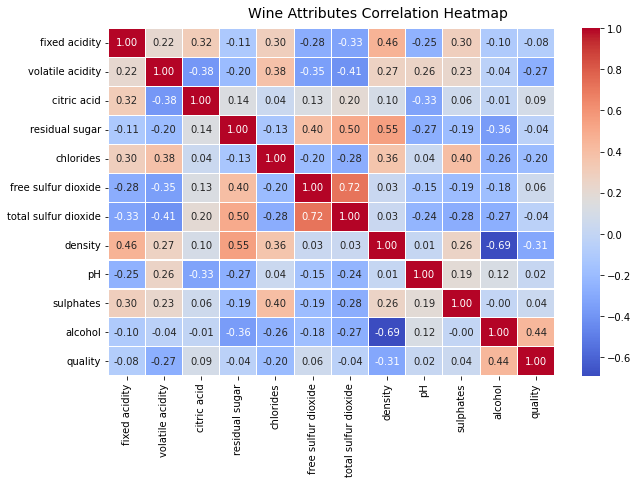

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
corr = wines.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
            linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Wine Attributes Correlation Heatmap', fontsize=14)

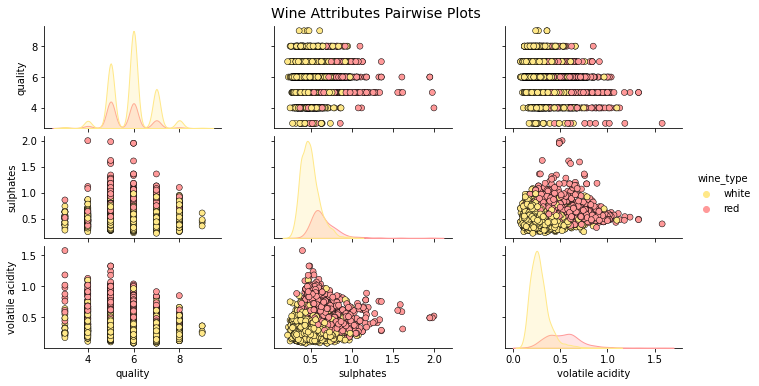

In [ ]:
cols = ['wine_type', 'quality', 'sulphates', 'volatile acidity']
pp = sns.pairplot(wines[cols], hue='wine_type', height=1.8, aspect=1.8, 
                  palette={"red": "#FF9999", "white": "#FFE888"},
                  plot_kws=dict(edgecolor="black", linewidth=0.5))
fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Wine Attributes Pairwise Plots', fontsize=14)

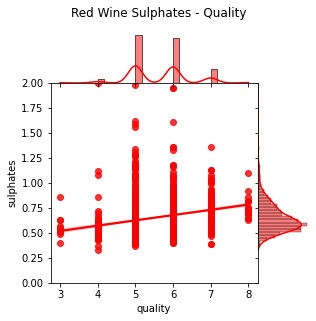

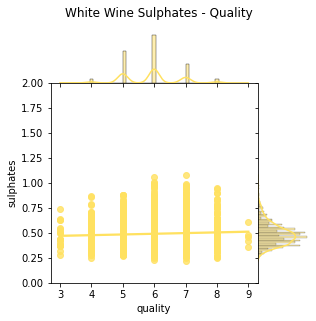

In [ ]:
rj = sns.jointplot(x='quality', y='sulphates', data=red_wine,
                   kind='reg', ylim=(0, 2),  
                   color='red', space=0, height=4.5, ratio=4)
rj.ax_joint.set_xticks(list(range(3,9)))
fig = rj.fig 
fig.subplots_adjust(top=0.9)
t = fig.suptitle('Red Wine Sulphates - Quality', fontsize=12)

wj = sns.jointplot(x='quality', y='sulphates', data=white_wine,
                   kind='reg', ylim=(0, 2),
                   color='#FFE160', space=0, height=4.5, ratio=4)
wj.ax_joint.set_xticks(list(range(3,10)))
fig = wj.fig 
fig.subplots_adjust(top=0.9)
t = fig.suptitle('White Wine Sulphates - Quality', fontsize=12)

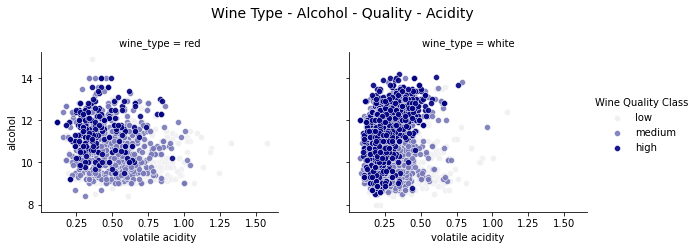

In [ ]:
g = sns.FacetGrid(wines, col="wine_type", hue='quality_label', 
                  col_order=['red', 'white'], hue_order=['low', 'medium', 'high'],
                  aspect=1.2, height=3.5, palette=sns.light_palette('navy', 3))
g.map(plt.scatter, "volatile acidity", "alcohol", alpha=0.9, 
      edgecolor='white', linewidth=0.5)
fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Wine Type - Alcohol - Quality - Acidity', fontsize=14)
l = g.add_legend(title='Wine Quality Class')

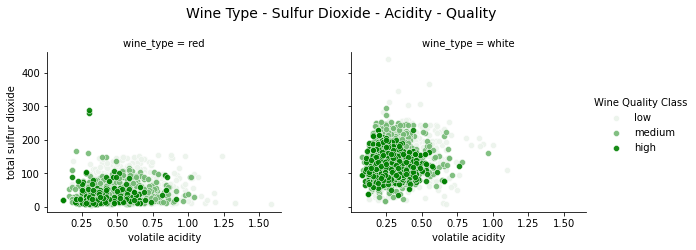

In [ ]:
g = sns.FacetGrid(wines, col="wine_type", hue='quality_label', 
                  col_order=['red', 'white'], hue_order=['low', 'medium', 'high'],
                  aspect=1.2, height=3.5, palette=sns.light_palette('green', 3))
g.map(plt.scatter, "volatile acidity", "total sulfur dioxide", alpha=0.9, 
      edgecolor='white', linewidth=0.5)
fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Wine Type - Sulfur Dioxide - Acidity - Quality', fontsize=14)
l = g.add_legend(title='Wine Quality Class')

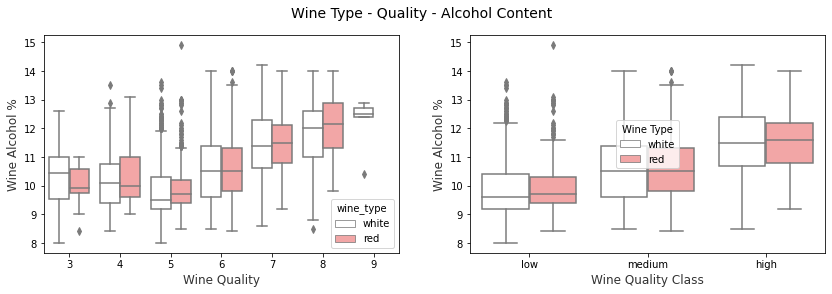

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
f.suptitle('Wine Type - Quality - Alcohol Content', fontsize=14)

sns.boxplot(x="quality", y="alcohol", hue="wine_type",
               data=wines, palette={"red": "#FF9999", "white": "white"}, ax=ax1)
ax1.set_xlabel("Wine Quality",size = 12,alpha=0.8)
ax1.set_ylabel("Wine Alcohol %",size = 12,alpha=0.8)

sns.boxplot(x="quality_label", y="alcohol", hue="wine_type",
               data=wines, palette={"red": "#FF9999", "white": "white"}, ax=ax2)
ax2.set_xlabel("Wine Quality Class",size = 12,alpha=0.8)
ax2.set_ylabel("Wine Alcohol %",size = 12,alpha=0.8)
l = plt.legend(loc='best', title='Wine Type')

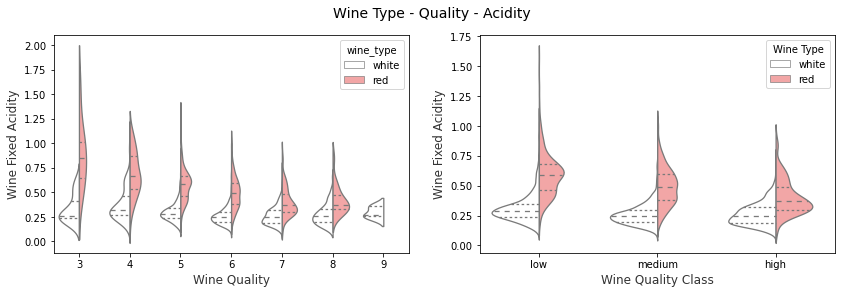

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
f.suptitle('Wine Type - Quality - Acidity', fontsize=14)

sns.violinplot(x="quality", y="volatile acidity", hue="wine_type", 
               data=wines, split=True, inner="quart", linewidth=1.3,
               palette={"red": "#FF9999", "white": "white"}, ax=ax1)
ax1.set_xlabel("Wine Quality",size = 12,alpha=0.8)
ax1.set_ylabel("Wine Fixed Acidity",size = 12,alpha=0.8)

sns.violinplot(x="quality_label", y="volatile acidity", hue="wine_type", 
               data=wines, split=True, inner="quart", linewidth=1.3,
               palette={"red": "#FF9999", "white": "white"}, ax=ax2)
ax2.set_xlabel("Wine Quality Class",size = 12,alpha=0.8)
ax2.set_ylabel("Wine Fixed Acidity",size = 12,alpha=0.8)
l = plt.legend(loc='upper right', title='Wine Type')

#Prepare data

In [ ]:
white_wine = pd.read_csv('winequality-white.csv', sep=';')
red_wine = pd.read_csv('winequality-red.csv', sep=';')

red_wine['wine_type'] = 'red'   # add a column for the type
white_wine['wine_type'] = 'white'
wines = pd.concat([red_wine, white_wine])
wines['quality_label'] = wines['quality'].apply(lambda value: 'low' 
                                                              if value <= 5 else 'medium' 
                                                                  if value <= 7 else 'high')
wines = wines.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
wqp_features = wines.iloc[:,:-3]
wqp_class_labels = np.array(wines['quality_label'])
wqp_label_names = ['low', 'medium', 'high']
wqp_feature_names = list(wqp_features.columns)
train_X, test_X, train_y, test_y = train_test_split(wqp_features, wqp_class_labels, 
                                                                    test_size=0.1, random_state=42)

print(Counter(train_y), Counter(test_y))
print('Features:', wqp_feature_names)

Counter({'medium': 3517, 'low': 2147, 'high': 183}) Counter({'medium': 398, 'low': 237, 'high': 15})
Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


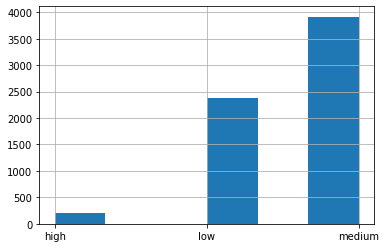

In [ ]:
wines['quality_label'].hist(bins=6)

In [ ]:
test_y[0]

'low'

In [ ]:
# Define the scaler 
wqp_ss = StandardScaler().fit(wqp_features)

# Scale the train set
wqp_train_SX = wqp_ss.transform(train_X)

# Scale the test set
wqp_test_SX = wqp_ss.transform(test_X)

#Build Model

In [ ]:
from sklearn.svm import LinearSVC
import xgboost as xgb
import lightgbm
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [ ]:
tree = DecisionTreeClassifier()
# rf = RandomForestClassifier(n_estimators=500, 
#                             max_features='auto',
#                             bootstrap=True, 
#                             class_weight='balanced', random_state=42)
rf = RandomForestClassifier(n_estimators=10000, 
                            max_features='auto',
                            bootstrap=True, 
                            class_weight='balanced', random_state=42)
xg = xgb.XGBClassifier(learning_rate= 0.01, max_depth=10, n_estimators =500)
lgbm = lightgbm.LGBMClassifier()
vote = VotingClassifier(estimators = [('rf',rf), ('xg',xg), ('lgbm',lgbm)],
                          voting='soft')
stack = StackingClassifier(estimators = [('xg',xg),('rf',rf)],
                           final_estimator = lgbm )

In [ ]:
max = 0
name = ''
for model in [tree, rf, xg, lgbm, vote, stack]:
  model.fit(train_X,train_y)
  y_pred = model.predict(test_X)
  print(model.__class__.__name__)
  print(classification_report(test_y, y_pred,labels=wqp_label_names))
  acc = accuracy_score(test_y, y_pred)
  if acc>max:
    max = acc
    name = model.__class__.__name__
print('Accuracy max:',name,max)

DecisionTreeClassifier
              precision    recall  f1-score   support

         low       0.71      0.68      0.70       237
      medium       0.80      0.80      0.80       398
        high       0.17      0.27      0.21        15

    accuracy                           0.74       650
   macro avg       0.56      0.58      0.57       650
weighted avg       0.75      0.74      0.75       650

RandomForestClassifier
              precision    recall  f1-score   support

         low       0.82      0.73      0.77       237
      medium       0.82      0.90      0.86       398
        high       1.00      0.20      0.33        15

    accuracy                           0.82       650
   macro avg       0.88      0.61      0.65       650
weighted avg       0.82      0.82      0.81       650

XGBClassifier
              precision    recall  f1-score   support

         low       0.75      0.70      0.72       237
      medium       0.81      0.86      0.84       398
        high   

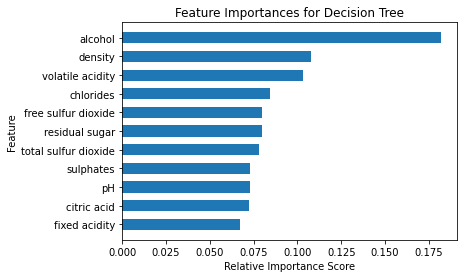

In [ ]:
wqp_dt_feature_importances = rf.feature_importances_
wqp_dt_feature_names, wqp_dt_feature_scores = zip(*sorted(zip(wqp_feature_names, wqp_dt_feature_importances), 
                                                          key=lambda x: x[1]))
y_position = list(range(len(wqp_dt_feature_names)))
plt.barh(y_position, wqp_dt_feature_scores, height=0.6, align='center')
plt.yticks(y_position , wqp_dt_feature_names)
plt.xlabel('Relative Importance Score')
plt.ylabel('Feature')
t = plt.title('Feature Importances for Decision Tree')

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
                'n_estimators': [800, 2000, 5000], 
                'max_features': ['auto', None, 'log2']    
              }

wqp_clf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=7,
                       scoring='accuracy')
wqp_clf.fit(train_X,train_y)
print(wqp_clf.best_params_)

{'max_features': None, 'n_estimators': 10000}


In [ ]:
print(wqp_clf.best_score_)

0.8140906839772267


In [ ]:
param_grid = {
                'n_estimators': [1000, 1500, 2000, 2500], 
                'learning_rate': [0.2, 0.3, 0.5]    
              }

wqp_clf = GridSearchCV(xgb.XGBClassifier(random_state=42), param_grid, cv=5,
                       scoring='accuracy')
wqp_clf.fit(train_X,train_y)
print(wqp_clf.best_params_)

In [ ]:
results = wqp_clf.cv_results_
for param, score_mean, score_sd in zip(results['params'], results['mean_test_score'], results['std_test_score']):
    print(param, round(score_mean, 4), round(score_sd, 4))

In [ ]:
label = wines['quality'].apply(lambda value: 0 if value <= 5 else 1 if value <= 7 else 2)

In [ ]:
target = label.values

In [ ]:
# train_X, test_X, train_y, test_y = train_test_split(wqp_features, target ,test_size=0.1, random_state=42)

In [ ]:
from keras.utils.np_utils import to_categorical

In [ ]:
train_y_cat = to_categorical(train_y, num_classes=3)
test_y_cat = to_categorical(test_y, num_classes=3)

In [ ]:
y_cat = to_categorical(target, num_classes=3)

In [ ]:
# Define the scaler 
wqp_ss = StandardScaler().fit(wqp_features)

# Scale the train set
wqp_train_SX = wqp_ss.transform(wqp_features)

# Scale the test set
# wqp_test_SX = wqp_ss.transform(test_X)

In [ ]:
!pip3 install keras-tuner --upgrade

In [ ]:
from keras.models import  Sequential
from keras.layers import Dense,Dropout
# from keras.optimizers import Adam
import keras_tuner as kt

In [ ]:
def build_model(hp):
  model = Sequential()
  model.add(Dense(hp.Int("units", min_value=32, max_value=512, step=32),activation='relu'))
  model.add(Dense(3, activation='softmax'))
  model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='accuracy',
    max_trials=10)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [ ]:
tuner.search(wqp_train_SX, y_cat, epochs=30)
best_model = tuner.get_best_models()[0]

INFO:tensorflow:Oracle triggered exit


In [ ]:
models = tuner.get_best_models(num_models=1)

In [ ]:
model = models[0]
model.build(input_shape=(None,11))

In [ ]:
# model = Sequential()
# model.add(Dense(256, activation='relu', kernel_initializer='he_normal',kernel_regularizer='l2', input_shape = (11,)))
# model.add(Dropout(0.3))
# model.add(Dense(256, activation='relu', kernel_initializer='he_normal',kernel_regularizer='l2'))
# model.add(Dropout(0.3))
# model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1536      
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,923
Trainable params: 1,923
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(wqp_train_SX, y_cat, batch_size=64, shuffle=True,validation_split=0.1, verbose=1, epochs=200)

In [ ]:
model.evaluate(wqp_train_SX, y_cat)

204/204 [==============================] - 1s 3ms/step - loss: 0.4244 - accuracy: 0.8222


[0.4243784546852112, 0.8222256302833557]